In [1]:
import glob
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import re

In [2]:
class Flattening():
    '''
    f_type: flatening type
        + type_1: ă, â, ê, ...
        + type_2: type_1 + {đ, ơ, ư}
    '''
    def __init__(self, f_type='type_1'):
        self.f_type = f_type
        self.accent2unicode = {'<6>': '\u0302', '<7>': '\u031B', '<8>': '\u0306', '<F>': '\u0300', \
                               '<S>': '\u0301', '<R>': '\u0309', '<X>': '\u0303', '<J>': '\u0323'}
        self.circumflex_unicodes = ['00C2', '00E2', '00CA', '00EA', '00D4', '00F4'] # â, Â, Ê, ...
        self.breve_unicodes = ['0102', '0103'] # ă, Ă
        self.underdot_unicodes = ['1EA0', '1EA1', '1EB8', '1EB9', '1ECC', '1ECD']
        self._7_unicodes = ['01A0', '01A1', '01AF', '01B0']
        self.accent_letters = 'À Á Ả Ã Ạ Â Ầ Ấ Ẩ Ẫ Ậ Ă Ằ Ắ Ẳ Ẵ Ặ à á ả ã ạ â ầ ấ ẩ ẫ ậ ă ằ ắ ẳ ẵ ặ\
        È É Ẻ Ẽ Ẹ Ê Ề Ế Ể Ễ Ệ è é ẻ ẽ ẹ ê ề ế ể ễ ệ\
        Ì Í Ỉ Ĩ Ị ì í ỉ ĩ ị\
        Ò Ó Ỏ Õ Ọ Ô Ồ Ố Ổ Ỗ Ộ Ơ Ờ Ớ Ở Ỡ Ợ ò ó ỏ õ ọ ô ồ ố ổ ỗ ộ ơ ờ ớ ở ỡ ợ\
        Ù Ú Ủ Ũ Ụ Ư Ừ Ứ Ử Ữ Ự ù ú ủ ũ ụ ư ừ ứ ử ữ ự\
        Ỳ Ý Ỷ Ỹ Ỵ ỳ ý ỷ ỹ ỵ'
        if self.f_type=='type_2':
            self.accent_letters += ' đ Đ'
        self.accent_letters = self.accent_letters.split()
    
    def get_unaccent(self, letter):
        letter = letter.encode('utf-8').decode('utf-8')
        if self.f_type == 'type_1':
            letter = re.sub(u'[àáảãạâầấẩẫậăằắẳẵặ]', 'a', letter)
            letter = re.sub(u'[ÀÁẢÃẠÂẦẤẨẪẬĂẰẮẲẴẶ]', 'A', letter)
            letter = re.sub(u'[èéẹẻẽêềếệểễ]', 'e', letter)
            letter = re.sub(u'[ÈÉẸẺẼÊỀẾỆỂỄ]', 'E', letter)
            letter = re.sub(u'[òóọỏõôồốộổỗ]', 'o', letter)
            letter = re.sub(u'[ÒÓỌỎÕÔỒỐỘỔỖ]', 'O', letter)
            letter = re.sub(u'[ơờớợởỡ]', 'ơ', letter)
            letter = re.sub(u'[ƠỜỚỢỞỠ]', 'Ơ', letter)
            letter = re.sub(u'[ìíịỉĩ]', 'i', letter)
            letter = re.sub(u'[ÌÍỊỈĨ]', 'I', letter)
            letter = re.sub(u'[ùúụủũ]', 'u', letter)
            letter = re.sub(u'[ÙÚỤỦŨ]', 'U', letter)
            letter = re.sub(u'[ưừứựửữ]', 'ư', letter)
            letter = re.sub(u'[ƯỪỨỰỬỮ]', 'Ư', letter)
            letter = re.sub(u'[ỳýỵỷỹ]', 'y', letter)
            letter = re.sub(u'[ỲÝỴỶỸ]', 'Y', letter)
            return letter
        elif self.f_type == 'type_2':
            letter = re.sub(u'đ', 'd', letter)
            letter = re.sub(u'Đ', 'D', letter)
            return ''.join(c for c in unicodedata.normalize('NFD', letter)\
                           if unicodedata.category(c) != 'Mn')
        else:
            raise ValueError('Should be: type_1 or type_2')

    def get_accents(self, letter):
        mark_accent, vowel_accent = None, None
        bi_unicode = unicodedata.decomposition(letter).split()

        if letter=='đ' or letter=='Đ':
            mark_accent = '<9>'
        elif bi_unicode[1]=='0302' or (bi_unicode[0] in self.circumflex_unicodes) or letter=='ậ' or letter=='Ậ':
            mark_accent = '<6>' # VNI '<CIRCUMFLEX>'
        elif bi_unicode[1]=='0306' or (bi_unicode[0] in self.breve_unicodes) or letter=='ặ' or letter=='Ặ':
            mark_accent = '<8>' # '<BREVE>'
        elif (self.f_type=='type_2') and (bi_unicode[1]=='031B' or (bi_unicode[0] in self._7_unicodes)):
            mark_accent = '<7>'
            
        if letter=='đ' or letter=='Đ':
            vowel_accent = None
        elif bi_unicode[1]=='0300':
            vowel_accent = '<F>'
        elif bi_unicode[1]=='0301':
            vowel_accent = '<S>'
        elif bi_unicode[1]=='0303':
            vowel_accent = '<X>'
        elif bi_unicode[1]=='0309':
            vowel_accent = '<R>'
        elif bi_unicode[1]=='0323' or (bi_unicode[0] in self.underdot_unicodes):
            vowel_accent = '<J>'

        return mark_accent, vowel_accent

    def flatten_letter(self, letter):
        if letter not in self.accent_letters:
            return letter, None, None
        unaccent_letter = self.get_unaccent(letter)
        mark_accent, vowel_accent = self.get_accents(letter)
        return unaccent_letter, mark_accent, vowel_accent
    
    def flatten_word(self, word):
        flattened_word = ''
        for letter in word:
            unaccent_letter, mark_accent, vowel_accent = self.flatten_letter(letter)
            flattened_word = flattened_word + unaccent_letter + (mark_accent if mark_accent!= None else '')\
            + (vowel_accent if vowel_accent!= None else '')
        return flattened_word
    
    def invert(self, flattened_word):
        accent_word = ''
        letters = re.findall(r'[\w]|<.*?>', flattened_word)
        for letter in letters:
            if len(letter) == 1:
                accent_word = accent_word + letter
            else: # accent
                if letter == '<9>':
                    accent_word = accent_word[:-1] + ('đ' if accent_word=='d' else 'Đ')
                else:
                    accent_word = accent_word + self.accent2unicode[letter]
                accent_word = unicodedata.normalize('NFC', accent_word)
        return accent_word

In [3]:
flattening = Flattening(f_type='type_1')
string = 'Bạn có thể đang tự cách ly, nhưng những suy nghĩ của bạn cứ không chịu ngồi yên'
for word in string.split():
    print(flattening.flatten_word(word))

Ba<J>n
co<S>
the<6><R>
đang
tư<J>
ca<S>ch
ly,
nhưng
như<X>ng
suy
nghi<X>
cu<R>a
ba<J>n
cư<S>
kho<6>ng
chi<J>u
ngo<6><F>i
ye<6>n


In [4]:
flattening = Flattening(f_type='type_2')
string = 'Bạn có thể đang tự cách ly, nhưng những suy nghĩ của bạn cứ không chịu ngồi yên'
for word in string.split():
    print(flattening.flatten_word(word))

Ba<J>n
co<S>
the<6><R>
d<9>ang
tu<7><J>
ca<S>ch
ly,
nhu<7>ng
nhu<7><X>ng
suy
nghi<X>
cu<R>a
ba<J>n
cu<7><S>
kho<6>ng
chi<J>u
ngo<6><F>i
ye<6>n


In [5]:
def plot_bar(cnt, title, img_name):
    fig = plt.figure(figsize=(20,10))
    plt.bar(cnt.keys(), cnt.values())
    plt.title(title, fontsize=20)
    plt.xlabel('Letter', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    fig.savefig(img_name, dpi=300)

In [6]:
def get_letters_count(flattening, fp):
    df = pd.read_csv(fp, sep='\t')
    words = df.loc[:, 'label'].astype(str)
    letter_list = []
    for word in words:
        flattened_word = flattening.flatten_word(word)
        letter_list.extend(re.findall(r'[\w]|<.*?>', flattened_word))
    letters_count = Counter(sorted(letter_list))
    return letters_count

In [7]:
flattening_1 = Flattening(f_type='type_1')
flattening_2 = Flattening(f_type='type_2')

# ALL SET

Counter({'n': 43466, 'a': 42092, '<6>': 33060, 'h': 31272, 'i': 27014, '<S>': 23720, 'o': 23437, 't': 21272, 'c': 20917, 'g': 20783, '<F>': 20247, '<J>': 17991, 'u': 15107, 'e': 15049, 'ư': 11634, '<R>': 10620, 'ơ': 9992, 'đ': 9467, 'm': 8665, 'r': 6022, 'y': 6011, 'l': 5881, 'v': 5731, '<X>': 5026, 'b': 4848, 'p': 4409, 'k': 4359, '<8>': 3136, 's': 3086, 'T': 2533, 'd': 2247, 'N': 1929, '0': 1922, 'x': 1845, 'q': 1669, 'C': 1627, 'H': 1199, '1': 1074, 'V': 1065, '2': 1012, 'B': 1008, 'Đ': 862, 'P': 755, 'S': 689, '3': 635, 'M': 531, 'D': 512, 'A': 498, 'L': 487, 'K': 457, '5': 441, '4': 314, 'X': 285, 'G': 276, 'Q': 273, '7': 225, 'U': 223, 'O': 221, '6': 208, '9': 200, '8': 176, 'I': 154, 'Y': 103, 'Ơ': 71, 'R': 65, 'E': 64, 'f': 26, 'j': 18, 'J': 17, 'W': 16, 'z': 4, 'Ư': 3, 'F': 1, 'ƒ': 1})


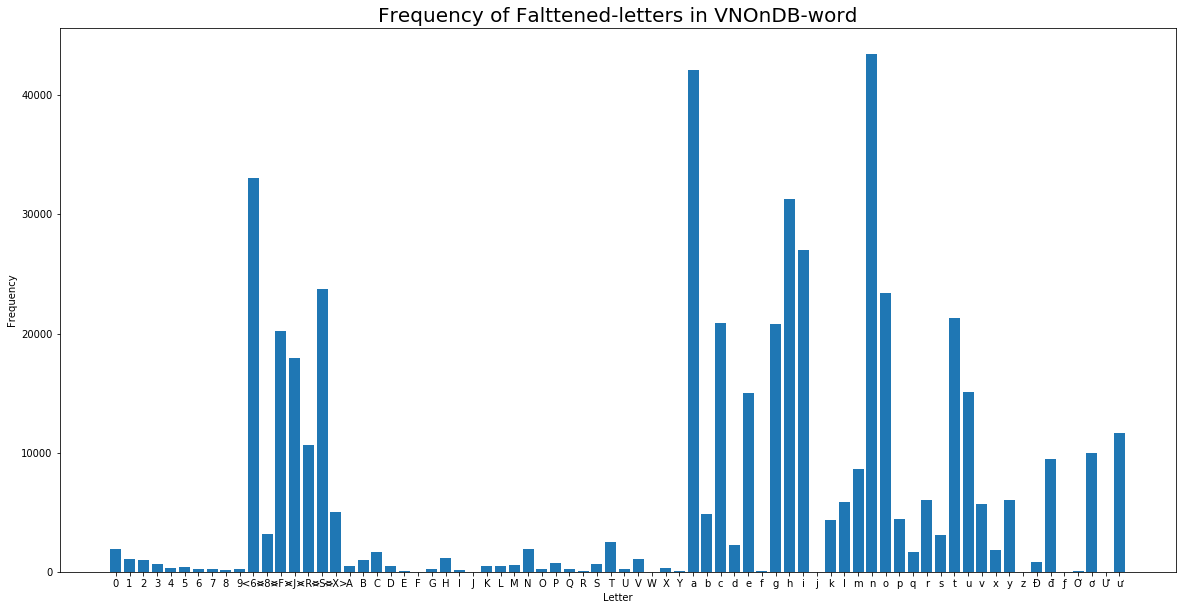

In [8]:
all_letters_cnt = get_letters_count(flattening_1, '../data/VNOnDB/all_word.csv')
print(all_letters_cnt)
plot_bar(all_letters_cnt, 'Frequency of Falttened-letters in VNOnDB-word', 'word_all/all_flattened_1_letter_frequency.jpg')

Counter({'n': 43466, 'a': 42092, 'o': 33429, '<6>': 33060, 'h': 31272, 'i': 27014, 'u': 26741, '<S>': 23720, '<7>': 21700, 't': 21272, 'c': 20917, 'g': 20783, '<F>': 20247, '<J>': 17991, 'e': 15049, 'd': 11714, '<R>': 10620, '<9>': 10329, 'm': 8665, 'r': 6022, 'y': 6011, 'l': 5881, 'v': 5731, '<X>': 5026, 'b': 4848, 'p': 4409, 'k': 4359, '<8>': 3136, 's': 3086, 'T': 2533, 'N': 1929, '0': 1922, 'x': 1845, 'q': 1669, 'C': 1627, 'D': 1374, 'H': 1199, '1': 1074, 'V': 1065, '2': 1012, 'B': 1008, 'P': 755, 'S': 689, '3': 635, 'M': 531, 'A': 498, 'L': 487, 'K': 457, '5': 441, '4': 314, 'O': 292, 'X': 285, 'G': 276, 'Q': 273, 'U': 226, '7': 225, '6': 208, '9': 200, '8': 176, 'I': 154, 'Y': 103, 'R': 65, 'E': 64, 'f': 26, 'j': 18, 'J': 17, 'W': 16, 'z': 4, 'F': 1, 'ƒ': 1})


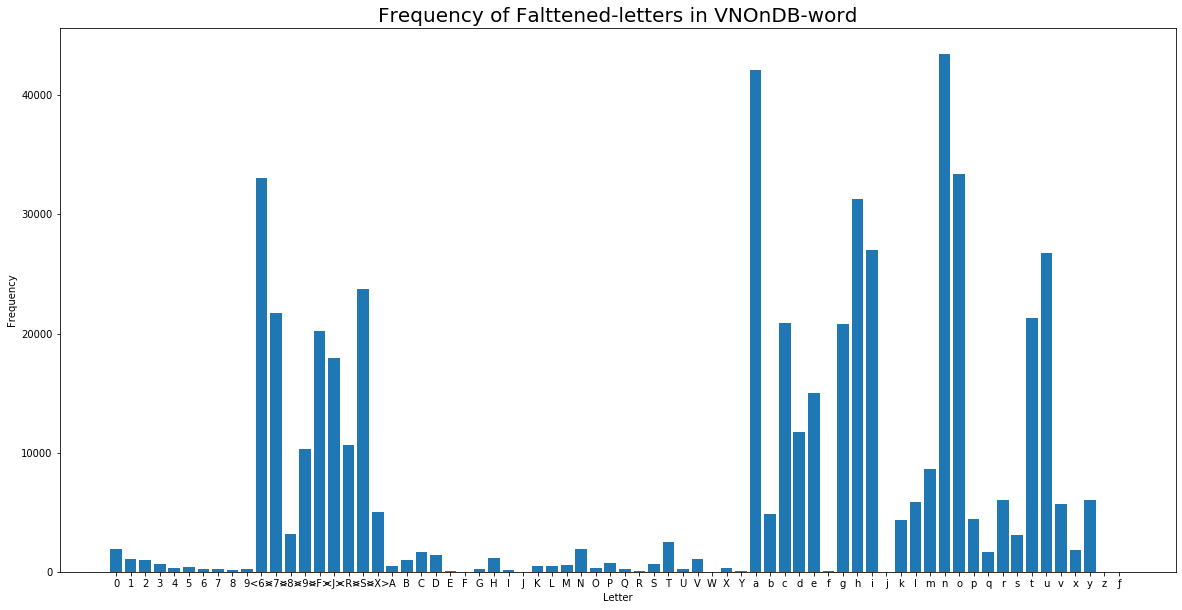

In [9]:
all_letters_cnt = get_letters_count(flattening_2, '../data/VNOnDB/all_word.csv')
print(all_letters_cnt)
plot_bar(all_letters_cnt, 'Frequency of Falttened-letters in VNOnDB-word', 'word_all/all_flattened_2_letter_frequency.jpg')

# TRAIN SET

Counter({'n': 26064, 'a': 25679, '<6>': 19847, 'h': 19102, 'i': 16361, '<S>': 14413, 'o': 14105, 't': 12946, 'c': 12617, '<F>': 12379, 'g': 12180, '<J>': 10927, 'e': 9158, 'u': 8986, 'ư': 6897, '<R>': 6719, 'ơ': 6090, 'đ': 5721, 'm': 5234, 'l': 3621, 'r': 3615, 'y': 3591, 'v': 3531, 'b': 3103, '<X>': 3029, 'p': 2632, 'k': 2618, 's': 1898, '<8>': 1867, 'T': 1505, 'd': 1364, 'N': 1268, '0': 1097, 'x': 1087, 'q': 1030, 'C': 926, 'H': 715, 'V': 646, '2': 612, '1': 587, 'B': 585, 'Đ': 585, 'P': 442, 'S': 399, '3': 378, 'A': 362, 'M': 317, 'L': 307, 'D': 294, '5': 266, 'K': 266, 'G': 182, '4': 173, 'Q': 170, 'X': 165, 'U': 154, '7': 147, '6': 128, '9': 126, 'O': 124, '8': 110, 'I': 88, 'E': 62, 'Y': 48, 'Ơ': 44, 'R': 31, 'W': 13, 'f': 11, 'j': 10, 'J': 6, 'z': 3, 'Ư': 3, 'F': 1})


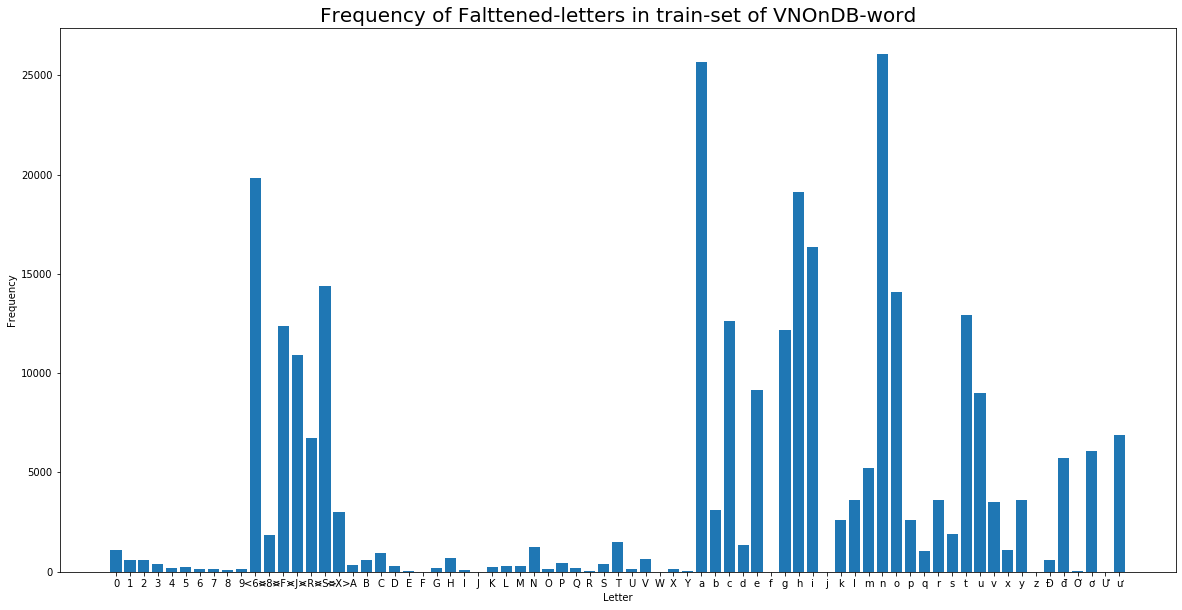

In [10]:
train_letters_cnt = get_letters_count(flattening_1, '../data/VNOnDB/train_word.csv')
print(train_letters_cnt)
plot_bar(train_letters_cnt, 'Frequency of Falttened-letters in train-set of VNOnDB-word', 'word_train/train_flattened_1_letter_frequency.jpg')

Counter({'n': 26064, 'a': 25679, 'o': 20195, '<6>': 19847, 'h': 19102, 'i': 16361, 'u': 15883, '<S>': 14413, '<7>': 13034, 't': 12946, 'c': 12617, '<F>': 12379, 'g': 12180, '<J>': 10927, 'e': 9158, 'd': 7085, '<R>': 6719, '<9>': 6306, 'm': 5234, 'l': 3621, 'r': 3615, 'y': 3591, 'v': 3531, 'b': 3103, '<X>': 3029, 'p': 2632, 'k': 2618, 's': 1898, '<8>': 1867, 'T': 1505, 'N': 1268, '0': 1097, 'x': 1087, 'q': 1030, 'C': 926, 'D': 879, 'H': 715, 'V': 646, '2': 612, '1': 587, 'B': 585, 'P': 442, 'S': 399, '3': 378, 'A': 362, 'M': 317, 'L': 307, '5': 266, 'K': 266, 'G': 182, '4': 173, 'Q': 170, 'O': 168, 'X': 165, 'U': 157, '7': 147, '6': 128, '9': 126, '8': 110, 'I': 88, 'E': 62, 'Y': 48, 'R': 31, 'W': 13, 'f': 11, 'j': 10, 'J': 6, 'z': 3, 'F': 1})


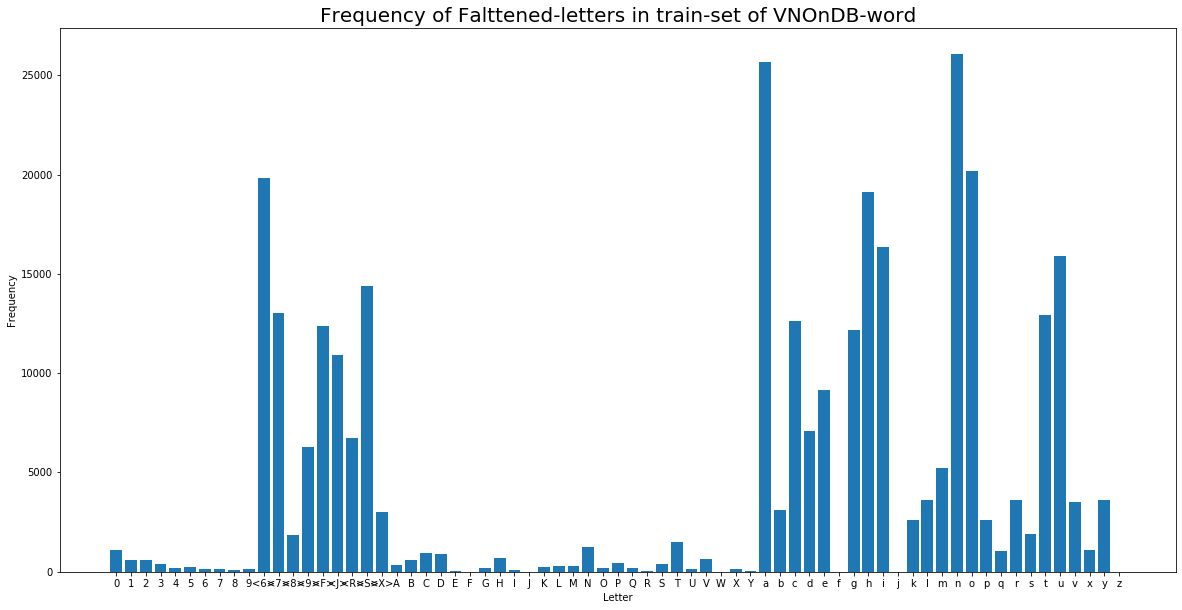

In [11]:
train_letters_cnt = get_letters_count(flattening_2, '../data/VNOnDB/train_word.csv')
print(train_letters_cnt)
plot_bar(train_letters_cnt, 'Frequency of Falttened-letters in train-set of VNOnDB-word', 'word_train/train_flattened_2_letter_frequency.jpg')

# VALIDATION SET

Counter({'n': 7402, 'a': 6875, '<6>': 5646, 'h': 5166, 'i': 4553, 'o': 4093, '<S>': 4091, 'g': 3784, 'c': 3634, 't': 3623, '<F>': 3450, '<J>': 2954, 'u': 2592, 'e': 2496, 'ư': 2050, 'ơ': 1673, 'đ': 1591, '<R>': 1580, 'm': 1493, 'r': 1091, 'y': 1009, 'l': 927, 'v': 895, '<X>': 826, 'p': 779, 'k': 776, 'b': 710, 's': 505, '<8>': 494, 'T': 461, '0': 331, 'x': 321, 'C': 310, 'd': 304, 'N': 302, 'q': 261, '1': 245, 'V': 203, 'B': 194, 'H': 174, '2': 165, 'P': 145, 'S': 105, '3': 104, 'M': 104, 'Đ': 101, 'D': 88, 'K': 75, '5': 69, '4': 66, 'L': 65, 'A': 61, '7': 47, 'G': 42, 'O': 42, '6': 41, 'Q': 40, 'X': 36, '8': 32, '9': 32, 'Ơ': 20, 'R': 17, 'I': 15, 'U': 11, 'J': 8, 'Y': 8, 'f': 3, 'j': 3, 'z': 1, 'ƒ': 1})


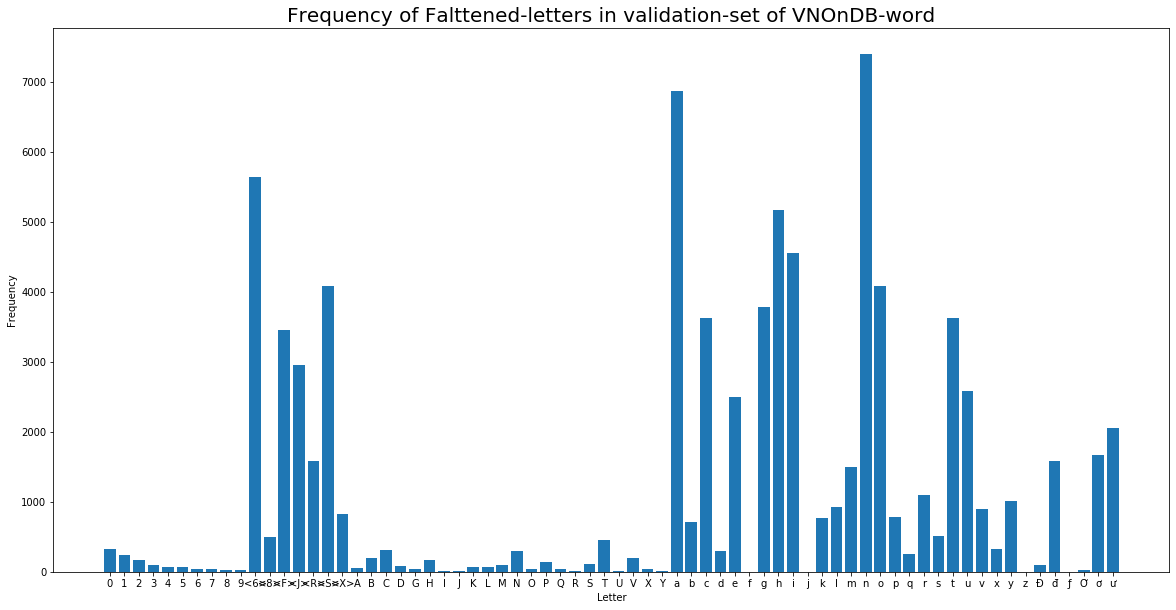

In [12]:
val_letters_cnt = get_letters_count(flattening_1, '../data/VNOnDB/validation_word.csv')
print(val_letters_cnt)
plot_bar(val_letters_cnt, 'Frequency of Falttened-letters in validation-set of VNOnDB-word', 'word_validation/val_flattened_1_letter_frequency.jpg')

Counter({'n': 7402, 'a': 6875, 'o': 5766, '<6>': 5646, 'h': 5166, 'u': 4642, 'i': 4553, '<S>': 4091, 'g': 3784, '<7>': 3743, 'c': 3634, 't': 3623, '<F>': 3450, '<J>': 2954, 'e': 2496, 'd': 1895, '<9>': 1692, '<R>': 1580, 'm': 1493, 'r': 1091, 'y': 1009, 'l': 927, 'v': 895, '<X>': 826, 'p': 779, 'k': 776, 'b': 710, 's': 505, '<8>': 494, 'T': 461, '0': 331, 'x': 321, 'C': 310, 'N': 302, 'q': 261, '1': 245, 'V': 203, 'B': 194, 'D': 189, 'H': 174, '2': 165, 'P': 145, 'S': 105, '3': 104, 'M': 104, 'K': 75, '5': 69, '4': 66, 'L': 65, 'O': 62, 'A': 61, '7': 47, 'G': 42, '6': 41, 'Q': 40, 'X': 36, '8': 32, '9': 32, 'R': 17, 'I': 15, 'U': 11, 'J': 8, 'Y': 8, 'f': 3, 'j': 3, 'z': 1, 'ƒ': 1})


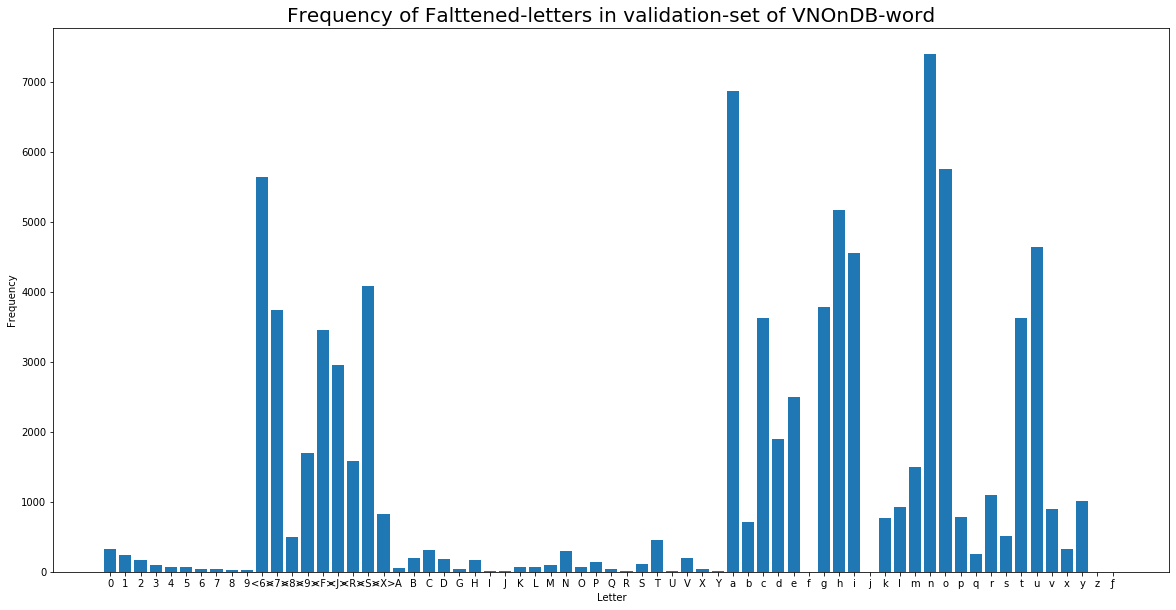

In [13]:
val_letters_cnt = get_letters_count(flattening_2, '../data/VNOnDB/validation_word.csv')
print(val_letters_cnt)
plot_bar(val_letters_cnt, 'Frequency of Falttened-letters in validation-set of VNOnDB-word', 'word_validation/val_flattened_2_letter_frequency.jpg')

# TEST SET

Counter({'n': 10000, 'a': 9538, '<6>': 7567, 'h': 7004, 'i': 6100, 'o': 5239, '<S>': 5216, 'g': 4819, 't': 4703, 'c': 4666, '<F>': 4418, '<J>': 4110, 'u': 3529, 'e': 3395, 'ư': 2687, '<R>': 2321, 'ơ': 2229, 'đ': 2155, 'm': 1938, 'y': 1411, 'l': 1333, 'r': 1316, 'v': 1305, '<X>': 1171, 'b': 1035, 'p': 998, 'k': 965, '<8>': 775, 's': 683, 'd': 579, 'T': 567, '0': 494, 'x': 437, 'C': 391, 'q': 378, 'N': 359, 'H': 310, '1': 242, '2': 235, 'B': 229, 'V': 216, 'S': 185, 'Đ': 176, 'P': 168, '3': 153, 'D': 130, 'K': 116, 'L': 115, 'M': 110, '5': 106, 'X': 84, '4': 75, 'A': 75, 'Q': 63, 'U': 58, 'O': 55, 'G': 52, 'I': 51, 'Y': 47, '9': 42, '6': 39, '8': 34, '7': 31, 'R': 17, 'f': 12, 'Ơ': 7, 'j': 5, 'J': 3, 'W': 3, 'E': 2})


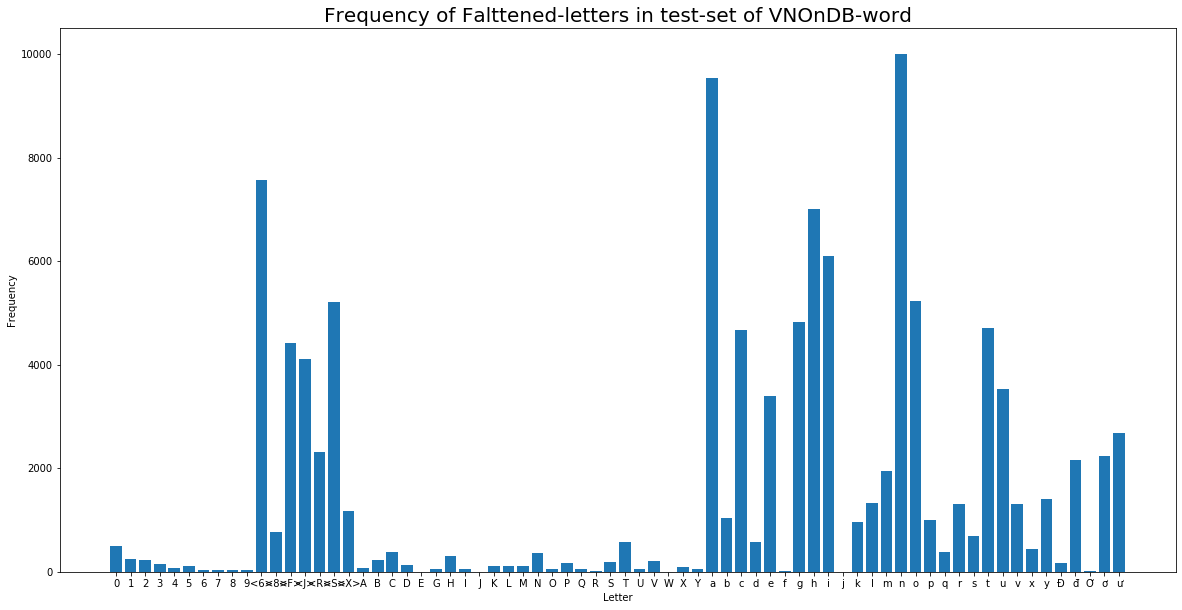

In [14]:
test_letters_cnt = get_letters_count(flattening_1, '../data/VNOnDB/test_word.csv')
print(test_letters_cnt)
plot_bar(test_letters_cnt, 'Frequency of Falttened-letters in test-set of VNOnDB-word', 'word_test/test_flattened_1_letter_frequency.jpg')

Counter({'n': 10000, 'a': 9538, '<6>': 7567, 'o': 7468, 'h': 7004, 'u': 6216, 'i': 6100, '<S>': 5216, '<7>': 4923, 'g': 4819, 't': 4703, 'c': 4666, '<F>': 4418, '<J>': 4110, 'e': 3395, 'd': 2734, '<9>': 2331, '<R>': 2321, 'm': 1938, 'y': 1411, 'l': 1333, 'r': 1316, 'v': 1305, '<X>': 1171, 'b': 1035, 'p': 998, 'k': 965, '<8>': 775, 's': 683, 'T': 567, '0': 494, 'x': 437, 'C': 391, 'q': 378, 'N': 359, 'H': 310, 'D': 306, '1': 242, '2': 235, 'B': 229, 'V': 216, 'S': 185, 'P': 168, '3': 153, 'K': 116, 'L': 115, 'M': 110, '5': 106, 'X': 84, '4': 75, 'A': 75, 'Q': 63, 'O': 62, 'U': 58, 'G': 52, 'I': 51, 'Y': 47, '9': 42, '6': 39, '8': 34, '7': 31, 'R': 17, 'f': 12, 'j': 5, 'J': 3, 'W': 3, 'E': 2})


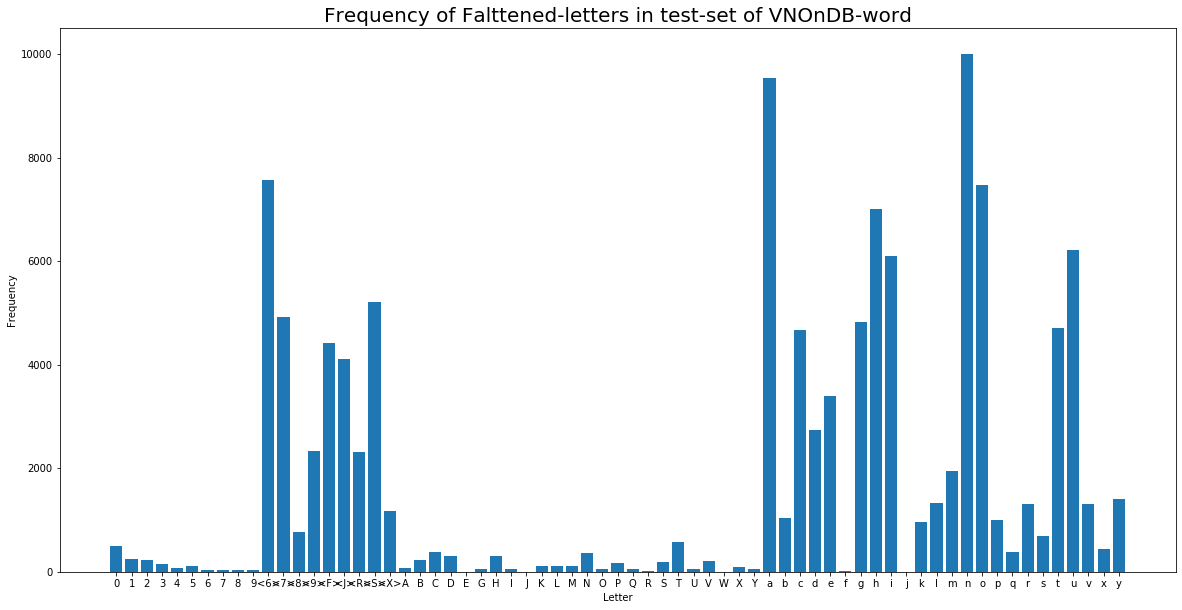

In [15]:
test_letters_cnt = get_letters_count(flattening_2, '../data/VNOnDB/test_word.csv')
print(test_letters_cnt)
plot_bar(test_letters_cnt, 'Frequency of Falttened-letters in test-set of VNOnDB-word', 'word_test/test_flattened_2_letter_frequency.jpg')